In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Pauli matrices
e = np.eye(2, dtype=complex)
x = np.array([[0, 1], [1, 0]], dtype=complex)
y = np.array([[0, -1j], [1j, 0]], dtype=complex)
z = np.array([[1, 0], [0, -1]], dtype=complex)
paulis = (e, x, y, z)

In [3]:
def multikron(matrices):
    """Tensor product of observables (aka Kronecker product)."""
    if len(matrices) == 2:
        return np.kron(matrices[0], matrices[1])
    else: 
        m1 = matrices.pop(0)
        matrices[0] = np.kron(m1, matrices[0])
        return multikron(matrices)

In [4]:
def projector(sgn, a, b, c, d):
    """Matrix that represents a measurement of Paulis a, b, c, d on qubits
    0, 1, 2, 3 respectively."""
    return (np.eye(16, dtype=complex) + sgn*multikron([paulis[i] for i in (a, b, c, d)]))/2

In [5]:
def entangled_state():
    """Maximally entangled 4-qubit state."""
    a = np.zeros(16, dtype=complex)
    a[[0, 5, 10, 15]] = 1
    return a/np.sqrt(4)

In [6]:
def measurement_prob(sgn, a, b, c, d, psi):
    """Probability of obtaining outcome sgn (-1 or +1)
    when we do a measurement of Paulis a, b, c, d on qubits
    0, 1, 2, 3."""
    return np.round(np.abs(psi@projector(sgn, a, b, c, d)@psi), decimals=2)

In [7]:
def post_measurement_state(p, sgn, a, b, c, d, psi):
    """State of the qubits after we do a measurement of Paulis
    a, b, c, d and obtain outcome sgn with probability p."""
#     print(p)
    assert p > 0 and p <= 1
    return projector(sgn, a, b, c, d)@psi/np.sqrt(p)

In [8]:
def measure(C, a, b, c, d, psi):
    """Measures Paulis a, b, c, d on qubits 0, 1, 2, 3
    respectively, with constant phase factor C.
    Returns the outcome of the measurement and the state
    after measurement."""
    possible_outcomes = (-1, 1)
    # Measurement probabilities
    p = np.array([measurement_prob(sgn, a, b, c, d, psi) for sgn in possible_outcomes])
    # Index for outcome
    i = np.random.choice([0, 1], p=p)
    outcome = possible_outcomes[i]
    # Post measurement state
    phi = post_measurement_state(p[i], outcome, a, b, c, d, psi)
    return C*outcome, phi

In [9]:
# Observables that Alice or Bob need to measure in order 
# to win the magic square game. The third entry is the sign, 
# so [1, 1, -1] means measure -XX
what_to_measure = np.array([
    [1, 0, 1], [0, 1, 1], [1, 1, -1],
    [0, 3, 1], [3, 0, 1], [3, 3, -1],
    [1, 3, 1], [3, 1, 1], [2, 2, -1]
    ]).reshape(3, 3, 3)

In [10]:
def entangulator(i, person, psi):
    """Measures the required observables on state psi to win the magic square
    game, given the row (column) number and the person Alice (Bob)
    who is measuring."""
    if person == 'alice':
        outcomes = []
        for m in what_to_measure[i]:
            outcome, phi = measure(m[2], m[0], m[1], 0, 0, psi)
            outcomes.append(outcome)
            psi = phi
    elif person == 'bob':
        outcomes = []
        for m in what_to_measure[:, i]:
            outcome, phi = measure(m[2], 0, 0, m[0], m[1], psi)
            outcomes.append(outcome)
            psi = phi
    else:
        raise ValueError("Who is {}".format(person))
    return np.array(outcomes), psi

In [11]:
def referee():
    return np.random.randint(0, 3, 2)

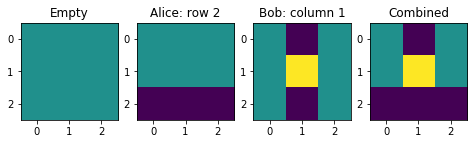

In [19]:
# Play the game
i, j = referee()
alice_outcomes, psi = entangulator(i, 'alice', entangled_state())
bob_outcomes, phi = entangulator(j, 'bob', psi)

# Visualize the results
empty_board = np.zeros((3, 3))
alice_board = np.copy(empty_board)
bob_board = np.copy(empty_board)
ab_board = np.copy(empty_board)

alice_board[i] = alice_outcomes
bob_board[:, j] = bob_outcomes
ab_board[i] = alice_outcomes
ab_board[:, j] = bob_outcomes

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].set_title('Empty')
ax[0].imshow(empty_board, vmin=-1, vmax=1)
ax[1].set_title('Alice: row {}'.format(i))
ax[1].imshow(alice_board, vmin=-1, vmax=1)
ax[2].set_title('Bob: column {}'.format(j))
ax[2].imshow(bob_board, vmin=-1, vmax=1)
ax[3].set_title('Combined')
ax[3].imshow(ab_board, vmin=-1, vmax=1)

In [13]:
def autoplay():
    """Play the optimal strategy automatically."""
    i, j = referee()
    alice_outcomes, psi = entangulator(i, 'alice', entangled_state())
    bob_outcomes, phi = entangulator(j, 'bob', psi)
    matching = alice_outcomes[j] == bob_outcomes[i]
    alice_parity = np.prod(alice_outcomes) == -1
    bob_parity = np.prod(bob_outcomes) == 1
    if matching and alice_parity and bob_parity:
        return True
    else:
        print(i, j)
        print(alice_outcomes)
        print(bob_outcomes)
        return False

In [20]:
# This will crash unless we win 100% of the time
for i in range(1000):
    assert autoplay()